In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (14,10)
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 8
plt.rcParams["xtick.major.width"] = 1.6
plt.rcParams["xtick.minor.width"] = 0.8
plt.rcParams["xtick.minor.size"] = 4
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.major.width"] = 1.6
plt.rcParams["ytick.minor.width"] = 0.8
plt.rcParams["ytick.major.size"] = 8
plt.rcParams["ytick.minor.size"] = 4
plt.rcParams["font.size"] = 24
plt.rcParams["lines.linewidth"] = 3
plt.rcParams["lines.markersize"] = 5
plt.rcParams["savefig.dpi"] = 300/2.4
plt.rcParams["savefig.transparent"] = False
plt.rcParams["savefig.facecolor"] = "white"

OUTPUT_DIR = "plots"
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [2]:
def load_benchmark_data(path):
    with open(path, "r") as fin:
        raw = json.load(fin)
    full = pd.DataFrame(raw["benchmarks"])
    full["real_time_μs"] = full["real_time"]/10**3
    full["cpu_time_μs"] = full["cpu_time"]/10**3
    if "error_occurred" not in full.columns:
        full["error_occurred"] = False
    full["error_occurred"].fillna(False, inplace=True)
    reduced = full[["run_name", "aggregate_name", "real_time_μs", "error_occurred"]]
    per_param = []
    for run_name, batch in reduced.groupby("run_name"):
        base_name, dof, nc = run_name.split("/")
        cur = {"name": base_name, "k": int(dof), "λ": int(nc)}
        per_param.append(cur)
        if np.all(batch["error_occurred"] == True):
            cur["error_occurred"] = True
            continue
        cols = ["median", "mean", "stddev"]
        vals = batch.set_index("aggregate_name").loc[cols, "real_time_μs"]
        cur.update(dict(zip(cols, vals), error_occurred=False))
    return pd.DataFrame.from_records(per_param)

In [3]:
input_dir = "100smallruns_double"
baseline = load_benchmark_data(f"{input_dir}/report.baseline.json")
new = load_benchmark_data(f"{input_dir}/report.new.json")

In [4]:
baseline["name"].value_counts()

fixed_nc            44
fixed_k             27
fixed_scale_0_05    11
fixed_scale_0_15    11
fixed_scale_0_25    11
Name: name, dtype: int64

In [5]:
def plot_fixed_k(ax, baseline, new, k):
    baseline[(baseline["name"] == "fixed_k") & (baseline["k"] == k)].sort_values("λ").plot(x="λ", y="mean", yerr="stddev", logx=True, ax=ax, label="baseline")
    new[(new["name"] == "fixed_k") & (new["k"] == k)].sort_values("λ").plot(x="λ", y="mean", yerr="stddev", logx=True, ax=ax, label="new")
    ax.axvline(k/0.25, ls="--", color="gray")
    ax.set_xlabel(f"λ");
    ax.set_ylabel("time, μs")
    name = f"boost_k_fixed_{k}"
    return name

In [6]:
baseline[baseline["name"] == "fixed_k"]["k"].value_counts()

15    9
2     9
50    9
Name: k, dtype: int64

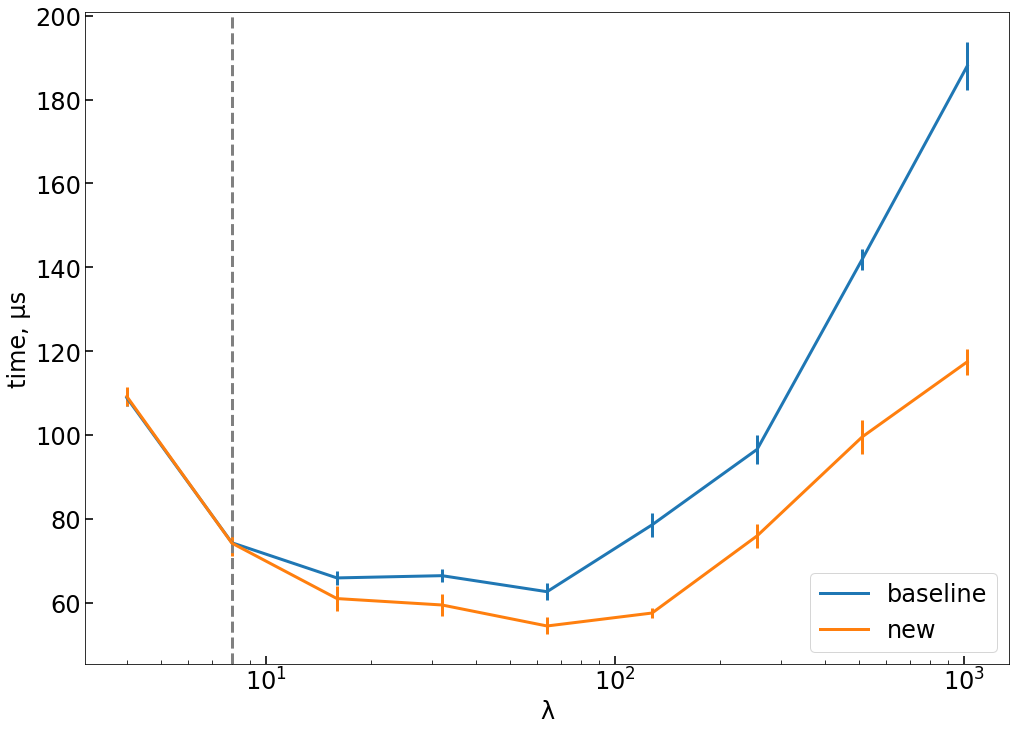

In [7]:
fig, ax = plt.subplots()
name = plot_fixed_k(ax, baseline, new, 2)
plt.savefig(f"{OUTPUT_DIR}/{name}.png")

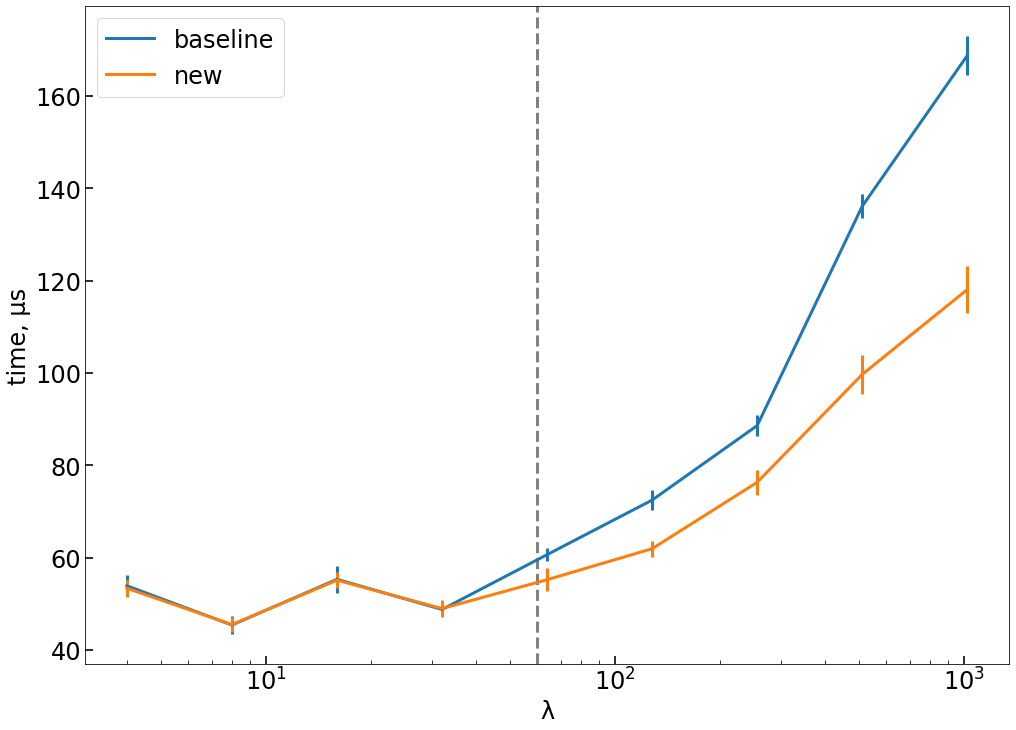

In [8]:
fig, ax = plt.subplots()
name = plot_fixed_k(ax, baseline, new, 15)
plt.savefig(f"{OUTPUT_DIR}/{name}.png")

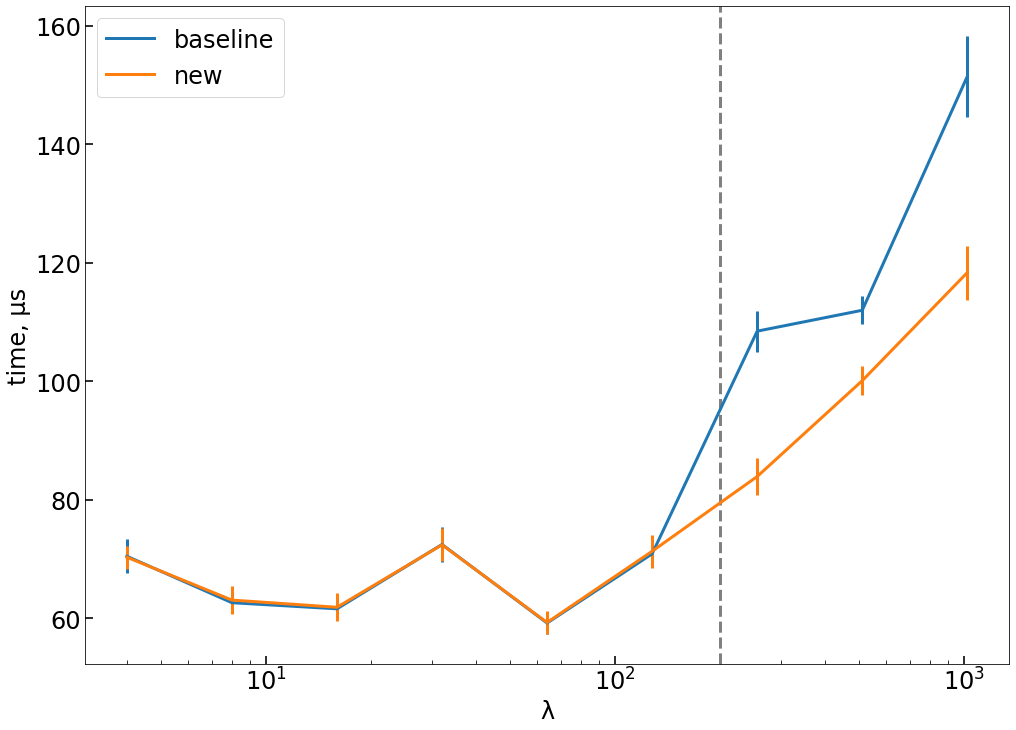

In [9]:
fig, ax = plt.subplots()
name = plot_fixed_k(ax, baseline, new, 50)
plt.savefig(f"{OUTPUT_DIR}/{name}.png")

In [10]:
baseline[baseline["name"] == "fixed_nc"]["λ"].value_counts()

1      11
100    11
30     11
500    11
Name: λ, dtype: int64

In [11]:
def plot_fixed_nc(ax, baseline, new, nc):
    baseline[(baseline["name"] == "fixed_nc") & (baseline["λ"] == nc)].sort_values("k").plot(x="k", y="mean", yerr="stddev", logx=True, ax=ax, label="baseline")
    new[(new["name"] == "fixed_nc") & (new["λ"] == nc)].sort_values("k").plot(x="k", y="mean", yerr="stddev", logx=True, ax=ax, label="new")
    ax.axvline(nc*0.25, ls="--", color="gray")
    ax.set_ylabel("time, μs")
    ax.set_xlabel(f"k")
    return f"boost_nc_fixed_{nc}"

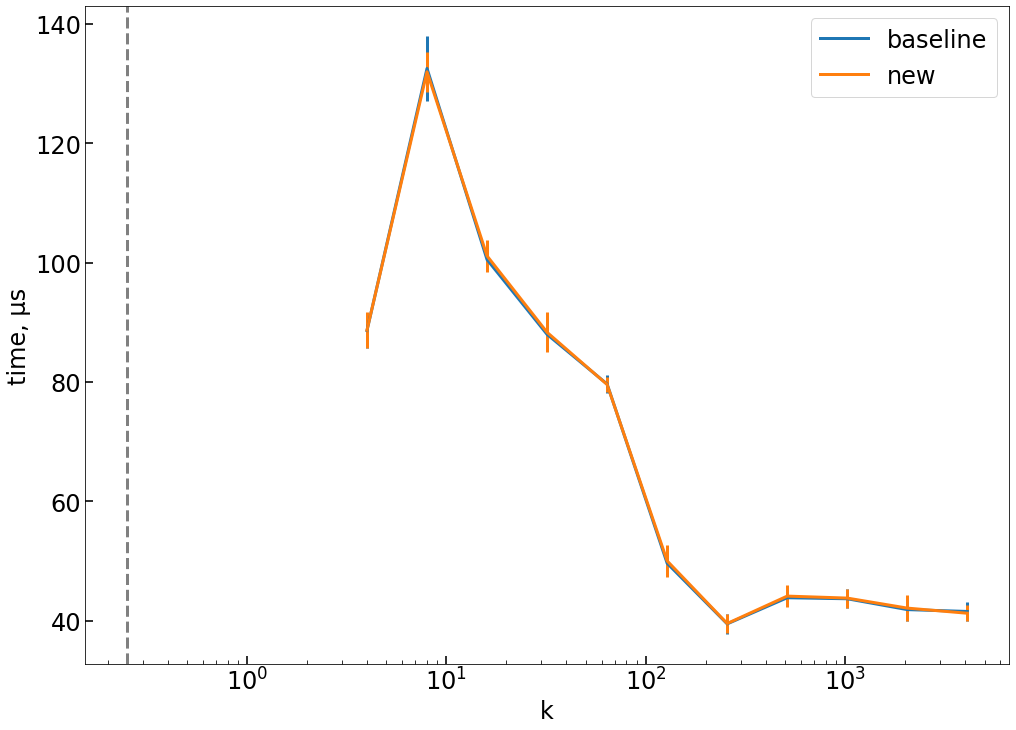

In [12]:
fig, ax = plt.subplots()
name = plot_fixed_nc(ax, baseline, new, 1)
plt.savefig(f"{OUTPUT_DIR}/{name}.png")

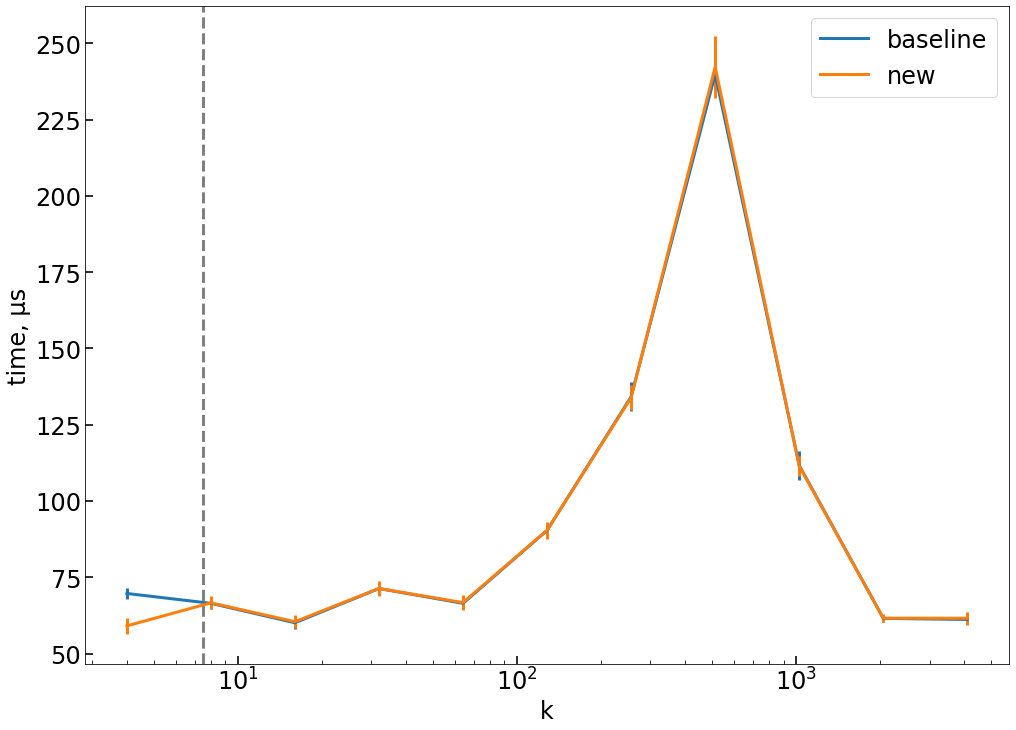

In [13]:
fig, ax = plt.subplots()
name = plot_fixed_nc(ax, baseline, new, 30)
plt.savefig(f"{OUTPUT_DIR}/{name}.png")

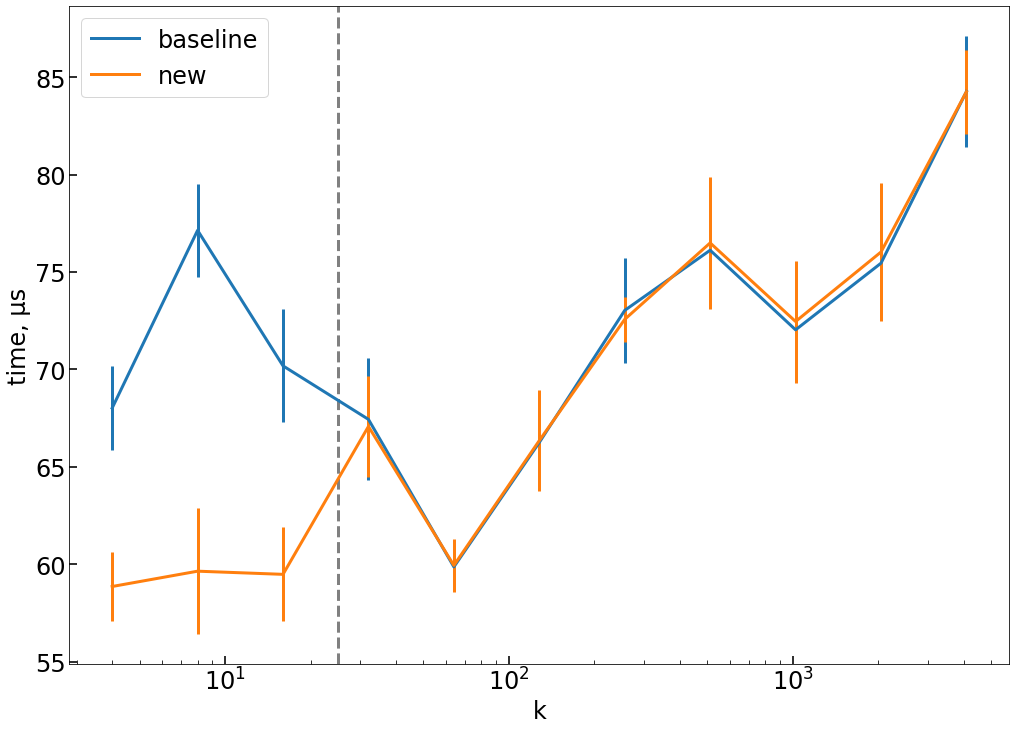

In [14]:
fig, ax = plt.subplots()
name = plot_fixed_nc(ax, baseline, new, 100)
plt.savefig(f"{OUTPUT_DIR}/{name}.png")

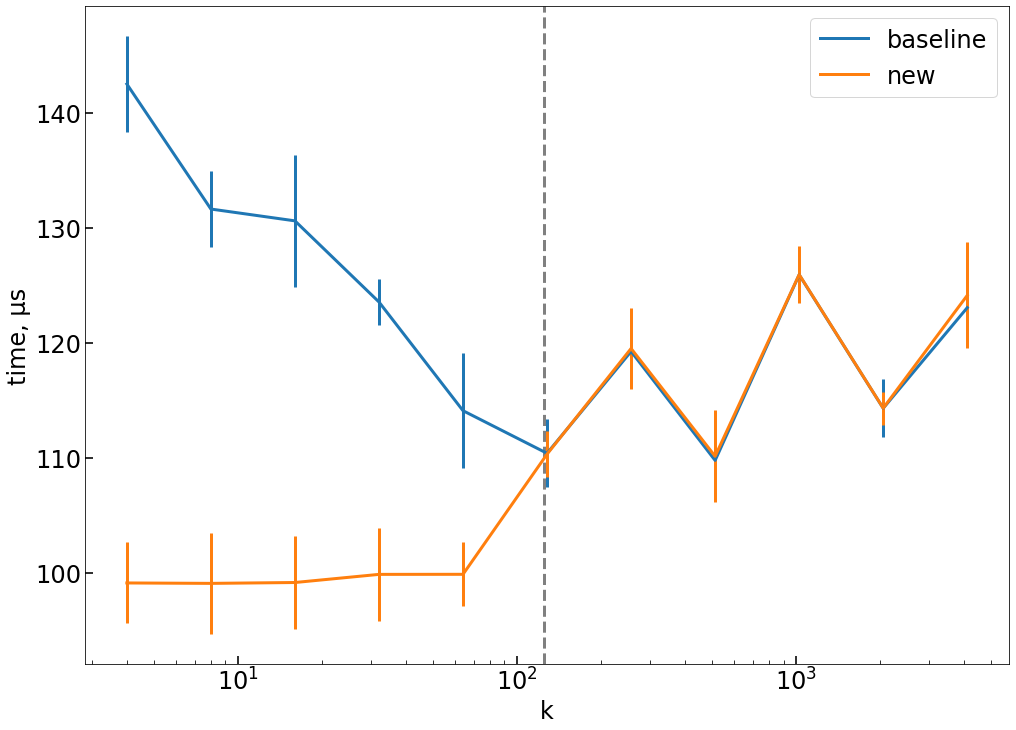

In [15]:
fig, ax = plt.subplots()
name = plot_fixed_nc(ax, baseline, new, 500)
plt.savefig(f"{OUTPUT_DIR}/{name}.png")

In [16]:
[i for i in baseline["name"].value_counts().index.values if i.startswith("fixed_scale")]

['fixed_scale_0_05', 'fixed_scale_0_15', 'fixed_scale_0_25']

In [17]:
def plot_fixed_scale(ax, baseline, new, name):
    baseline[(baseline["name"] == name)].sort_values("k").plot(x="k", y="mean", yerr="stddev", logx=True, ax=ax, label="baseline")
    new[(new["name"] == name)].sort_values("k").plot(x="k", y="mean", yerr="stddev", logx=True, ax=ax, label="new")
    scale_a, scale_b = name.split("_")[-2:]
    scale = f"{scale_a}.{scale_b}"
    ax.set_ylabel("time, μs")
    ax.set_xlabel(f"k")
    name = f"boost_scale_fixed_{scale_a}_{scale_b}"
    return name

/home/vindex10/projects/venvs/sandbox/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1061: UserWarning: Warning: converting a masked element to nan.
  x = np.asanyarray(x)
/home/vindex10/projects/venvs/sandbox/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1061: UserWarning: Warning: converting a masked element to nan.
  x = np.asanyarray(x)


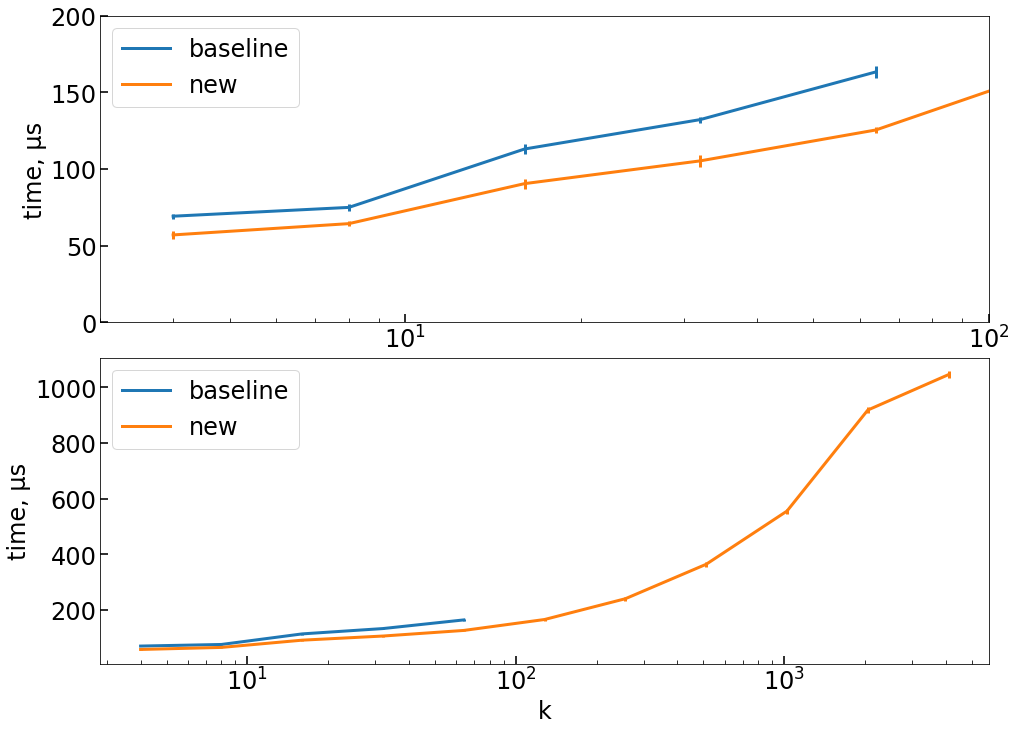

In [18]:
fig, ax = plt.subplots(nrows=2)
name = plot_fixed_scale(ax[0], baseline, new, "fixed_scale_0_05")
ax[0].set_xlim([3, 100])
ax[0].set_ylim([0, 200])
ax[0].set_xlabel(None)
name = plot_fixed_scale(ax[1], baseline, new, "fixed_scale_0_05")
plt.savefig(f"{OUTPUT_DIR}/{name}.png")

/home/vindex10/projects/venvs/sandbox/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1061: UserWarning: Warning: converting a masked element to nan.
  x = np.asanyarray(x)
/home/vindex10/projects/venvs/sandbox/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1061: UserWarning: Warning: converting a masked element to nan.
  x = np.asanyarray(x)


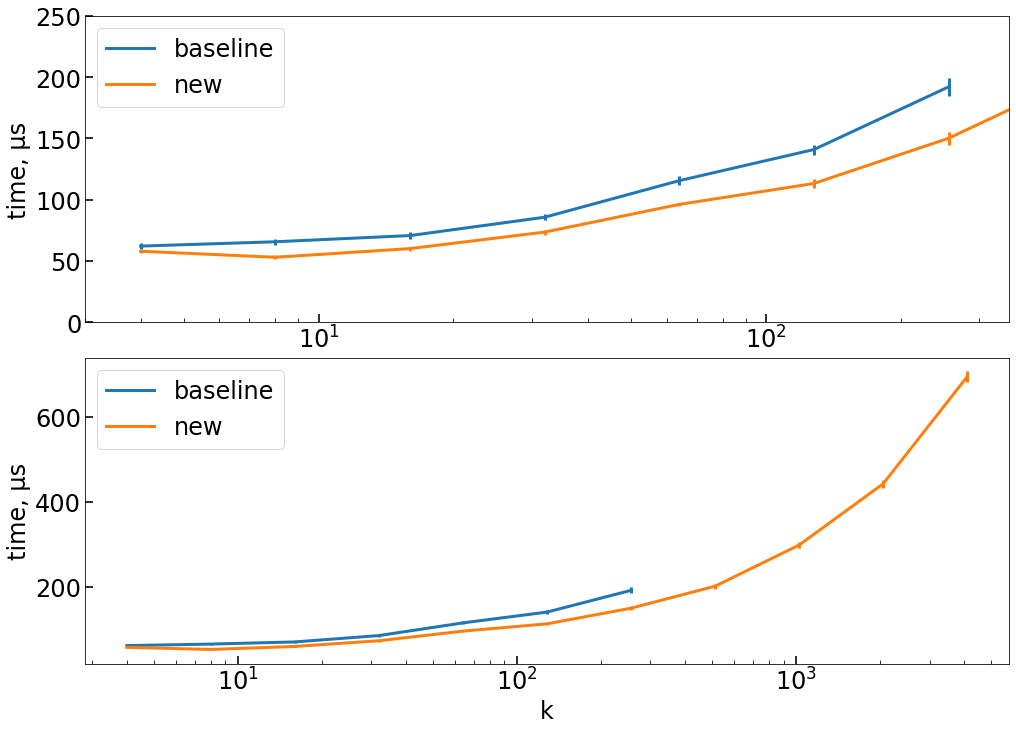

In [19]:
fig, ax = plt.subplots(nrows=2)
name = plot_fixed_scale(ax[0], baseline, new, "fixed_scale_0_15")
ax[0].set_xlim([3, 350])
ax[0].set_ylim([0, 250])
ax[0].set_xlabel(None)
name = plot_fixed_scale(ax[1], baseline, new, "fixed_scale_0_15")
plt.savefig(f"{OUTPUT_DIR}/{name}.png")

/home/vindex10/projects/venvs/sandbox/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1061: UserWarning: Warning: converting a masked element to nan.
  x = np.asanyarray(x)
/home/vindex10/projects/venvs/sandbox/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1061: UserWarning: Warning: converting a masked element to nan.
  x = np.asanyarray(x)


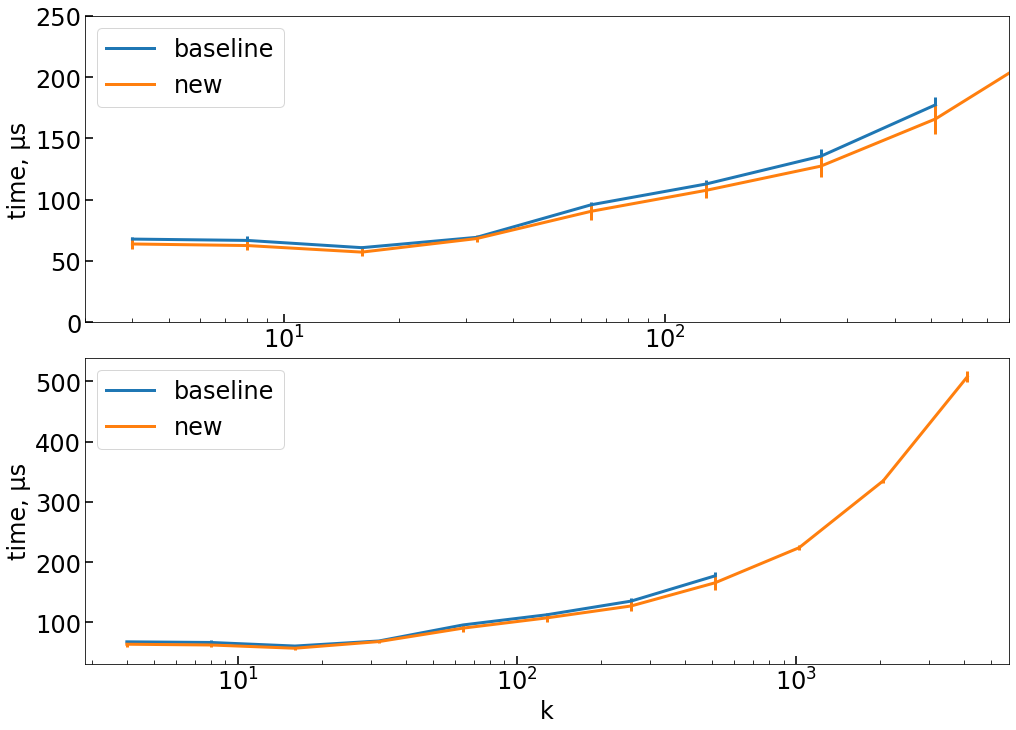

In [20]:
fig, ax = plt.subplots(nrows=2)
name = plot_fixed_scale(ax[0], baseline, new, "fixed_scale_0_25")
ax[0].set_xlim([3, 800])
ax[0].set_ylim([0, 250])
ax[0].set_xlabel(None)
name = plot_fixed_scale(ax[1], baseline, new, "fixed_scale_0_25")
plt.savefig(f"{OUTPUT_DIR}/{name}.png")